# Monte-Carlo iterations

In [1]:
%load_ext autoreload
%autoreload 2

import cfr

## Create a reconstruction job object

In [2]:
job = cfr.ReconJob(verbose=True)
print(job)

>>> job.configs:
{}


## Load a proxy database

In [37]:
df = pd.read_pickle('./data/pages2k_dataset.pkl')
mask = df['paleoData_pages2kID'] == 'Ocn_103'
idx = df[mask].index.values[0]

In [21]:
import pandas as pd
df_palmyra = pd.read_table('./data/palmyra2013.txt', skiprows=118)
df_palmyra

,age,d18O
0,928.125,-4.651
1,928.209,-4.631
2,928.292,-4.629
3,928.375,-4.562
4,928.459,-4.580
...,...,...
6379,1998.044,-5.435
6380,1998.127,-5.493
6381,1998.210,-5.469
6382,1998.294,-5.413


In [38]:
df.loc[idx, 'year'] = df_palmyra['age'].values
df.loc[idx, 'paleoData_values'] = df_palmyra['d18O'].values
df.loc[idx, 'dataSetName'] = 'Ocn-Palmyra.Emil-Geay.2013'

In [40]:
df.to_pickle('./data/pages2k_updated_Palmyra_dataset.pkl')

In [41]:
# job.load_proxydb('./data/pages2k_dataset.pkl', verbose=True)
job.load_proxydb('./data/pages2k_updated_Palmyra_dataset.pkl', verbose=True)

>>> job.configs["proxydb_path"] = ./data/pages2k_updated_Palmyra_dataset.pkl
>>> 692 records loaded
>>> job.proxydb created


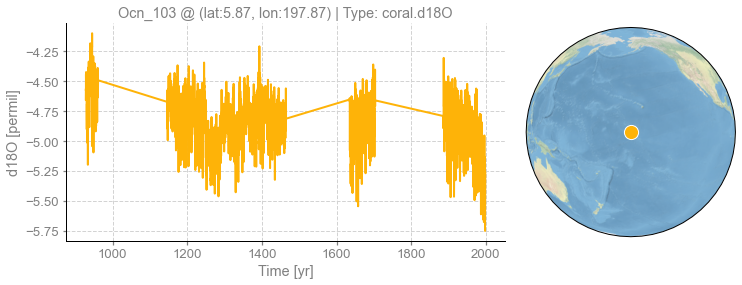

In [42]:
fig, ax = job.proxydb.records['Ocn_103'].plot()

## Filter a proxy database

>>> 13 records remaining
>>> job.proxydb updated


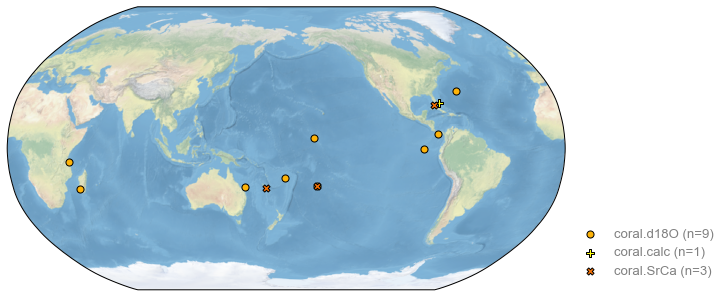

In [4]:
pids = [
    'Ocn_065',
    'Ocn_075',
    'Ocn_096',
    'Ocn_101',
    'Ocn_070',
    'Ocn_103',
    'Ocn_077',
    'Ocn_122',
    'Ocn_138',
    'Ocn_095',
    'Ocn_104',
    'Ocn_125',
    'Ocn_087',
]
job.filter_proxydb(by='pid', keys=pids, verbose=True)
fig, ax = job.proxydb.plot()

## Annualize/seasonalize the proxy database

In [5]:
# we only annualize coral records
job.annualize_proxydb(months=[12, 1, 2], ptypes=['coral'], verbose=True)

>>> job.configs["annualize_proxydb_months"] = [12, 1, 2]
>>> job.configs["annualize_proxydb_ptypes"] = ['coral']


Annualizing ProxyRecord: 100%|██████████| 13/13 [00:01<00:00,  7.89it/s]

>>> 13 records remaining
>>> job.proxydb updated


## Load climate model priors

In [6]:
job.load_clim(
    tag='prior',
    path_dict={
        'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc',
    },
    anom_period=[1951, 1980],
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './data/tas_sfc_Amon_iCESM_past1000historical_085001-200512.nc'}
>>> job.configs["prior_anom_period"] = [1951, 1980]
>>> job.configs["prior_lon_name"] = lon
>>> prior variables ['tas'] loaded
>>> job.prior created


## Load instrumental observations

In [7]:
job.load_clim(
    tag='obs',
    path_dict={
        'tas': './data/gistemp1200_ERSSTv4.nc',
    },
    rename_dict={'tas': 'tempanomaly'},
    anom_period=[1951, 1980],
    verbose=True,
)

>>> job.configs["obs_path"] = {'tas': './data/gistemp1200_ERSSTv4.nc'}
>>> job.configs["obs_rename_dict"] = {'tas': 'tempanomaly', 'pr': 'precip'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lon_name"] = lon
>>> obs variables ['tas'] loaded
>>> job.obs created


## Calibrate the PSMs

In [8]:
ptype_psm_dict = {
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'coral.calc': 'Linear',
}
ptype_season_dict = {
    'coral.d18O': [12, 1, 2],
    'coral.SrCa': [12, 1, 2],
    'coral.calc': [12, 1, 2],
}
job.calib_psms(ptype_psm_dict=ptype_psm_dict, ptype_season_dict=ptype_season_dict, verbose=True)

>>> job.configs["ptype_psm_dict"] = {'coral.d18O': 'Linear', 'coral.SrCa': 'Linear', 'coral.calc': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'coral.d18O': [12, 1, 2], 'coral.SrCa': [12, 1, 2], 'coral.calc': [12, 1, 2]}
>>> job.configs["psm_calib_period"] = [1850, 2015]


Calibrating the PSMs::  77%|███████▋  | 10/13 [00:00<00:00, 16.07it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:: 100%|██████████| 13/13 [00:00<00:00, 15.21it/s]

>>> The PSM for Ocn_138 failed to calibrate.
>>> 12 records tagged "calibrated" with ProxyRecord.psm created


## Forward the PSMs

In [9]:
job.forward_psms(verbose=True)

Forwarding the PSMs:: 100%|██████████| 12/12 [00:03<00:00,  3.36it/s]

>>> ProxyRecord.pseudo created for 12 records


In [10]:
# let's add the pids into the configurations
job.mark_pids(verbose=True)

>>> job.configs["pids"] = ['Ocn_065', 'Ocn_075', 'Ocn_096', 'Ocn_101', 'Ocn_070', 'Ocn_103', 'Ocn_077', 'Ocn_122', 'Ocn_138', 'Ocn_095', 'Ocn_104', 'Ocn_125', 'Ocn_087']


## Annualize/seasonalize the climate model prior

In [11]:
job.annualize_clim(tag='prior', verbose=True, months=[12, 1, 2])

>>> job.configs["prior_annualize_months"] = [12, 1, 2]
>>> Processing tas ...
>>> job.prior updated


In [12]:
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)
# job.prior['tas'].da

>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...


## Saving the `job` object

In [13]:
job.save(save_dirpath='./data/exp_mc', verbose=True)

>>> job.configs["save_dirpath"] = ./data/exp_mc
>>> job saved to: ./data/exp_mc


## Load the `job` object

In [14]:
import pandas as pd
job = pd.read_pickle('./data/exp_mc/job.pkl')

## Data assimilation

In [15]:
job.run_mc(recon_seeds=list(range(20)), verbose=True)

>>> job.configs["recon_period"] = [0, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_seeds"] = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["compress_params"] = {'zlib': True, 'least_significant_digit': 1}
>>> job.configs["output_full_ens"] = False
>>> seed: 0 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:17<00:00, 112.12it/s]


>>> Reconstructed fields saved to: ./data/exp_mc/job_r00_recon.nc
>>> seed: 1 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:24<00:00, 81.36it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r01_recon.nc
>>> seed: 2 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 74.32it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r02_recon.nc
>>> seed: 3 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:25<00:00, 77.84it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r03_recon.nc
>>> seed: 4 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:27<00:00, 72.41it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r04_recon.nc
>>> seed: 5 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:28<00:00, 70.58it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r05_recon.nc
>>> seed: 6 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 76.16it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r06_recon.nc
>>> seed: 7 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:27<00:00, 72.19it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r07_recon.nc
>>> seed: 8 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 74.89it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r08_recon.nc
>>> seed: 9 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:27<00:00, 73.56it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r09_recon.nc
>>> seed: 10 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 74.85it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r10_recon.nc
>>> seed: 11 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 76.66it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r11_recon.nc
>>> seed: 12 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:25<00:00, 78.45it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r12_recon.nc
>>> seed: 13 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:25<00:00, 79.47it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r13_recon.nc
>>> seed: 14 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 75.27it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r14_recon.nc
>>> seed: 15 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:28<00:00, 69.37it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r15_recon.nc
>>> seed: 16 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:28<00:00, 71.27it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r16_recon.nc
>>> seed: 17 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:27<00:00, 71.54it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r17_recon.nc
>>> seed: 18 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:26<00:00, 76.17it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r18_recon.nc
>>> seed: 19 | max: 19


KF updating: 100%|██████████| 2001/2001 [00:31<00:00, 62.64it/s] 


>>> Reconstructed fields saved to: ./data/exp_mc/job_r19_recon.nc
>>> DONE!


## Save the configurations to a YAML file

In [16]:
job.save_cfg(verbose=True)

>>> job.configs saved to: ./data/exp_mc/configs.yml
